<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S7/S7_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device : ",device)

Device :  cuda


**---------DataSet Pre-processing------------------**

In [2]:
transform = transforms.Compose( [transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose( [transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomCrop(32, padding=2),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),
                                       #transforms.RandomRotation( degrees = 7 ),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform = train_transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 4,
                                          shuffle=True, 
                                          num_workers = 4)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 4,
                                         shuffle=False,
                                         num_workers = 4)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  car plane   dog   cat


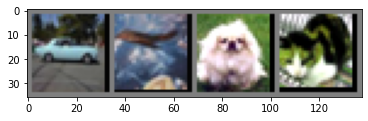

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**------------------Neural Network Model Defination---------------------- **

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(3, 6, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.conv1 = nn.Sequential( nn.Conv2d(3,50,3,padding = 2), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(50) ,
                                    nn.Conv2d(50,100,3,padding = 1,groups = 50),
                                    nn.ReLU() ,
                                    nn.BatchNorm2d(100),
                                    nn.Dropout(0.1) ) # Receptive Field = 6 , Output Resolution = 32*32*100
        self.pool1 = nn.Sequential( nn.MaxPool2d(2,2) ) # Receptive Field = 7 Output Resolution = 16*16*100
        self.conv2 = nn.Sequential( nn.Conv2d(100,200,3,padding = 1 ,dilation = 2), 
                                    nn.ReLU() ,
                                    nn.BatchNorm2d(200),
                                    nn.Dropout(0.1) ) # Receptive Field = 11 , Output Resolution = 16*16*200
        self.pool2 = nn.Sequential( nn.MaxPool2d(2,2) ) # Receptve Field = 13 , Output Resolution = 8*8*200
        self.conv3 = nn.Sequential( nn.Conv2d(200,400,3,padding = 2 ), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(400) ) #Receptive Field = 21 , Output Resolution = 10*10*500
        self.pool3 = nn.Sequential( nn.MaxPool2d(2,2) ) # Receptive Field = 25
        self.conv4 = nn.Sequential( nn.Conv2d(400,10,3,padding = 1),
                                    #nn.ReLU()
                                    #nn.BatchNorm2d(10),
                                    #nn.Conv2d(256,10,3) 
                                    ) # Receptive Feild = 41 , Output Resolution = 5*5*10
        self.gap = nn.Sequential( nn.AvgPool2d(4) ) #Receptive Field = 73
       #self.gap = nn.Sequential( nn.nn.AvgPool2d(kernel_size = 5) )


    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)


net = Net().to(device)

**-------------------------------Model View-----------------------------**

In [5]:
!pip install torchsummary
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 50, 34, 34]           1,400
              ReLU-2           [-1, 50, 34, 34]               0
       BatchNorm2d-3           [-1, 50, 34, 34]             100
            Conv2d-4          [-1, 100, 34, 34]           1,000
              ReLU-5          [-1, 100, 34, 34]               0
       BatchNorm2d-6          [-1, 100, 34, 34]             200
           Dropout-7          [-1, 100, 34, 34]               0
         MaxPool2d-8          [-1, 100, 17, 17]               0
            Conv2d-9          [-1, 200, 15, 15]         180,200
             ReLU-10          [-1, 200, 15, 15]               0
      BatchNorm2d-11          [-1, 200, 15, 15]             400
          Dropout-12          [-1, 200, 15, 15]               0
        MaxPool2d-13            [-1, 200, 7, 7]               0
           Conv2d-14            [-1, 40

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9 , weight_decay = 0.001 )
scheduler= StepLR(optimizer,step_size=5,gamma=0.1)

***----------------------------Model Training------------------------------***

In [7]:
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device) , data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  2000] loss: 1.841
[1,  4000] loss: 1.430
[1,  6000] loss: 1.280
[1,  8000] loss: 1.137
[1, 10000] loss: 1.062
[1, 12000] loss: 0.972
[2,  2000] loss: 0.911
[2,  4000] loss: 0.884
[2,  6000] loss: 0.866
[2,  8000] loss: 0.847
[2, 10000] loss: 0.806
[2, 12000] loss: 0.812
[3,  2000] loss: 0.765
[3,  4000] loss: 0.739
[3,  6000] loss: 0.738
[3,  8000] loss: 0.736
[3, 10000] loss: 0.723
[3, 12000] loss: 0.709
[4,  2000] loss: 0.678
[4,  4000] loss: 0.680
[4,  6000] loss: 0.665
[4,  8000] loss: 0.660
[4, 10000] loss: 0.667
[4, 12000] loss: 0.658
[5,  2000] loss: 0.613
[5,  4000] loss: 0.626
[5,  6000] loss: 0.614
[5,  8000] loss: 0.631
[5, 10000] loss: 0.622
[5, 12000] loss: 0.648
[6,  2000] loss: 0.576
[6,  4000] loss: 0.589
[6,  6000] loss: 0.604
[6,  8000] loss: 0.587
[6, 10000] loss: 0.597
[6, 12000] loss: 0.594
[7,  2000] loss: 0.581
[7,  4000] loss: 0.556
[7,  6000] loss: 0.571
[7,  8000] loss: 0.568
[7, 10000] loss: 0.591
[7, 12000] loss: 0.577
[8,  2000] loss: 0.542
[8,  4000] 

GroundTruth:    cat  ship  ship plane


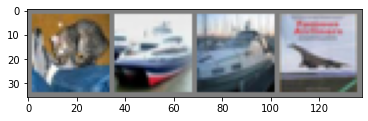

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
'''outputs = net(images)'''

'outputs = net(images)'

In [10]:
'''_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))'''

"_, predicted = torch.max(outputs, 1)\n\nprint('Predicted: ', ' '.join('%5s' % classes[predicted[j]]\n                              for j in range(4)))"

**----------------Model Evalution---------------------------**

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device) , data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 82 %


**------------------------Model Class Wise Evaluation-----------------**

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device) , data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of plane : 86 %
Accuracy of   car : 92 %
Accuracy of  bird : 80 %
Accuracy of   cat : 64 %
Accuracy of  deer : 75 %
Accuracy of   dog : 72 %
Accuracy of  frog : 87 %
Accuracy of horse : 86 %
Accuracy of  ship : 83 %
Accuracy of truck : 91 %
